# Inherint Bias present within different embeddings

## Overview

In this notebook, we will look at several different configurations of datasets, models, and embeddings to determine if any of the embedding/model combinations appear to show more bias than others. We will start by training 3 different model archetectures on 2 different datasets using 2 different embeddings to classify sentences/words as positive or negative (Sentiment analysis). Once we have the models trained, we will look at a curated set of names and throw sentences such as "Hello, my name is (Name)" to see if there is a signifigant difference between the percieved seniment scores of the sentences.

### Datasets that we will use
We will be leveraging two different datasets. The first is one from kaggle that has sentiment scores as either positive or negative that was curated from twitter (this dataset is at the sentence level https://www.kaggle.com/datasets/kazanova/sentiment140/discussion/454347). The second dataset is the one that we utilized in class and is labeled at an individual word level (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). We chose to use two different datasets in order to get a fair comparison between the different embeddings. We will be using a similar technique that we saw in class, taking the sentiment for each word in a sentence and averaging the sentiment score across it, as well as concating the embedding vectors for a sentence together, running PCA on it to reduce down to 300 dimensions and classifying at the sentence level. This was necessary because BERT was designed to take into the entire context of a sentence, not just a single word at a time. We hypothesize that the BERT embeddings will be signifigantly better at the sentence level compared to GLOVE, but we are interested in seeing how BERT will perform in the word level classification with an average sentiment value.

### Models that we will use
We will be leveraging 3 different classifier archetictures to feed the BERT and GLOVE embeddings into for sentiment analysis to see if one of the model archetectures further contrubutes to an inherint bias. The model archetectures that we will use will be as follows:
- A simple deep neural network (1 64 neuron layer, a dropout layer, and a single neuron layer to output the sentiment score)
- A simple LogisticRegression classifier
- A recurrent neural net (TODO: Will/Rick talk more on this archetecture)

### Embeddings that we will use
We will be leveraging both the glove.840B.300d and a BERT embedding. 
#### GLOVE
The glove embedding is just a simple download and lookup table in order to extract the vector for a single word. When we are using GLOVE with a sentence, we took two approaches. Firstly, we took the embedding for each word, classified each word with a sentiment score, and then averaged across the sentence. The second approach of getting a sentiment score for a sentence was to concatinate the vectors of each word in the sentence, and then run a PCA decomposition on those vectors to get back into a 300 dimensional vector. (The vectors that were not the length of the max length were padded with 0 vectors to meet the max length) ie. `[[0.4, 0.3, 0.2, 0.6],[0.1, 0.1]]` -> `[[0.4, 0.3, 0.2],[0.1, 0.1, 0.0, 0.0]]`
#### BERT
The second embedding that we wanted to lookat was a BERT embedding. This was a bit more complicated to obtain than the lookup table of glove. We feed each sentence(or word if we are doing the word based approach) into BERT and steal the last hidden layer for that sentence. Once we have that vector (768 dimensions), we run a PCA decomposition in order to compress it down to 300 dimensions so that we can feed these embeddings into the same classifiers.

__NOTE:__ The PCA decomposition was fit to ONLY the training set and was used to transform the test and validation sets used in training in order to avoid cross contamination between the training testing and validation sets 

## Code

### Data preparation
In this section, we grab the two datasets and label them `sentence_df` and `word_df` for the tweet dataset and the sentiment lexicon from class respectivley. We also create the Generator object that is responsible for getting different embeddings given a dataframe and splitting them into train, test, and validation sets. See `embeddings.py` for the implementation of this class.

In [9]:
from embeddings import EmbeddingGenerator
import helpers
import pandas as pd
import numpy as np

gen = EmbeddingGenerator(only_bert=False,cached_embedding_path = '../../data/concept_net/cached_embeddings') # Creating a Generator object that handles all of the embedding conversions

sentence_df = helpers.pre_process_input_data(filepath='../../data/concept_net/tweets.csv',num_samples=500) # Getting the data from the tweet dataset
pos_words = helpers.load_lexicon('../../data/concept_net/positive-words.txt')
neg_words = helpers.load_lexicon('../../data/concept_net/negative-words.txt')
word_df = pd.concat([ #Convert pos and neg words into single dataframe with labels
    pd.DataFrame({'word':pos_words,'target':[1] * len(pos_words)}),
    pd.DataFrame({'word':neg_words,'target':[0] * len(neg_words)})
])

del pos_words #Clear up ram because god knows this project eats a lot of it 
del neg_words

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

<Axes: >

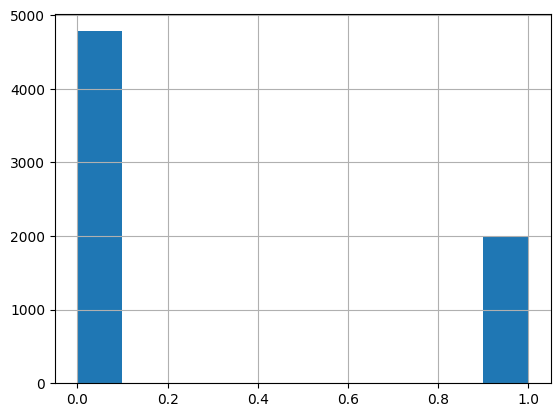

In [10]:
word_df['target'].hist()

<Axes: >

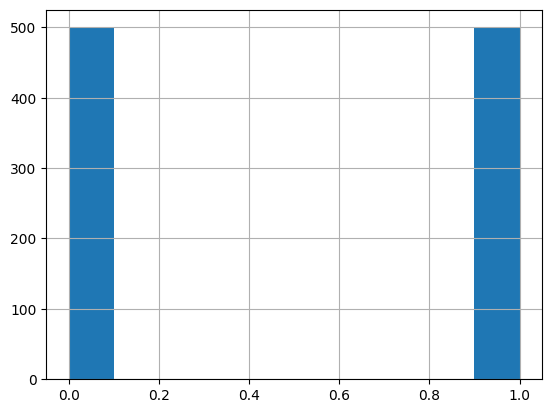

In [11]:
sentence_df['target'].hist()